In [1]:
import config

import os
from Bio import SeqIO
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import re
import warnings
import os
from hyena_dna.standalone_hyenadna import HyenaDNAModel, CharacterTokenizer
import torch
import pickle

os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
os.chdir(config.DIR_ROOT)

/Users/nad/miniconda3/envs/mobiraph1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n = 3
path_to_load = os.path.join(config.DIR_INCEST_MANY, f'hyena_model_output_correct_examples.pkl')
with open(path_to_load, "rb") as f:
    loaded_data = pickle.load(f)

In [4]:
names = loaded_data['names']
types = loaded_data['types']
sequences = loaded_data['sequences']
outputs = loaded_data['outputs']

In [5]:
output = outputs[0][0]
output.shape

torch.Size([2635, 256])

In [6]:
output = output[1:-1]

Helitron-N2C_CGi_Helitron_Crassostrea_gigas


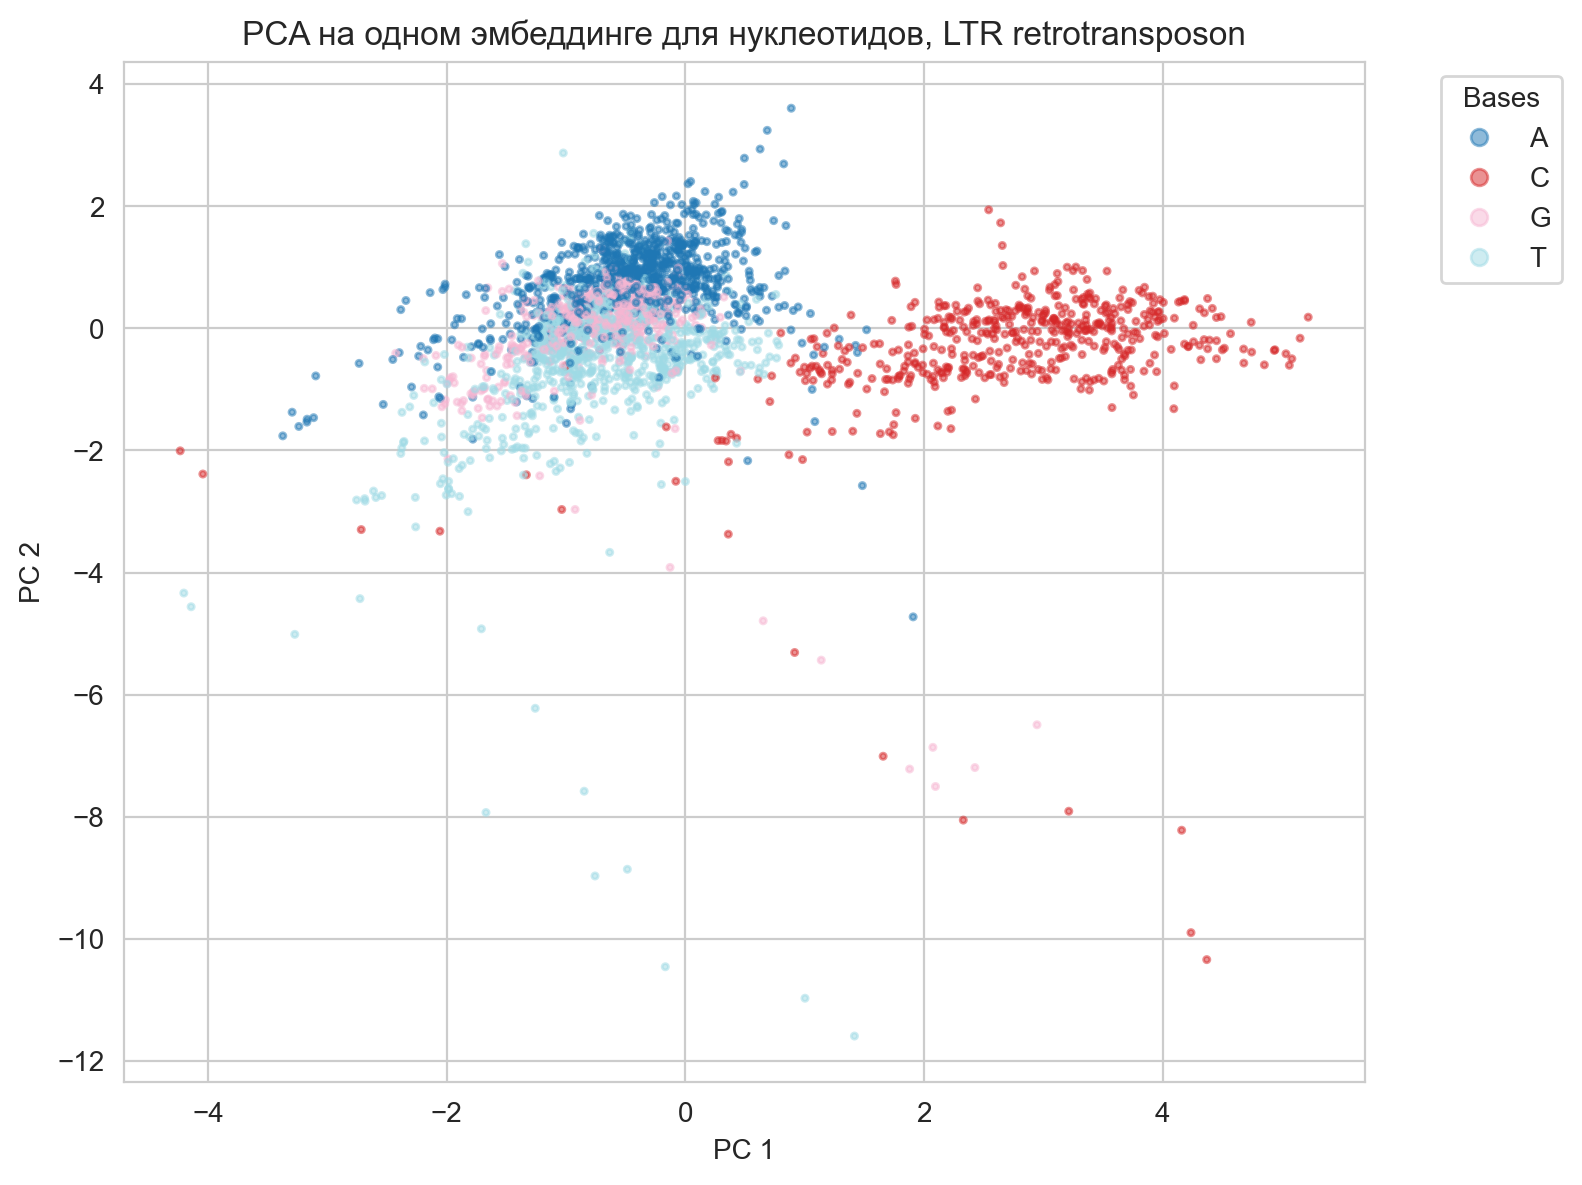

ATCOPIA97I_Copia_Arabidopsis_thaliana


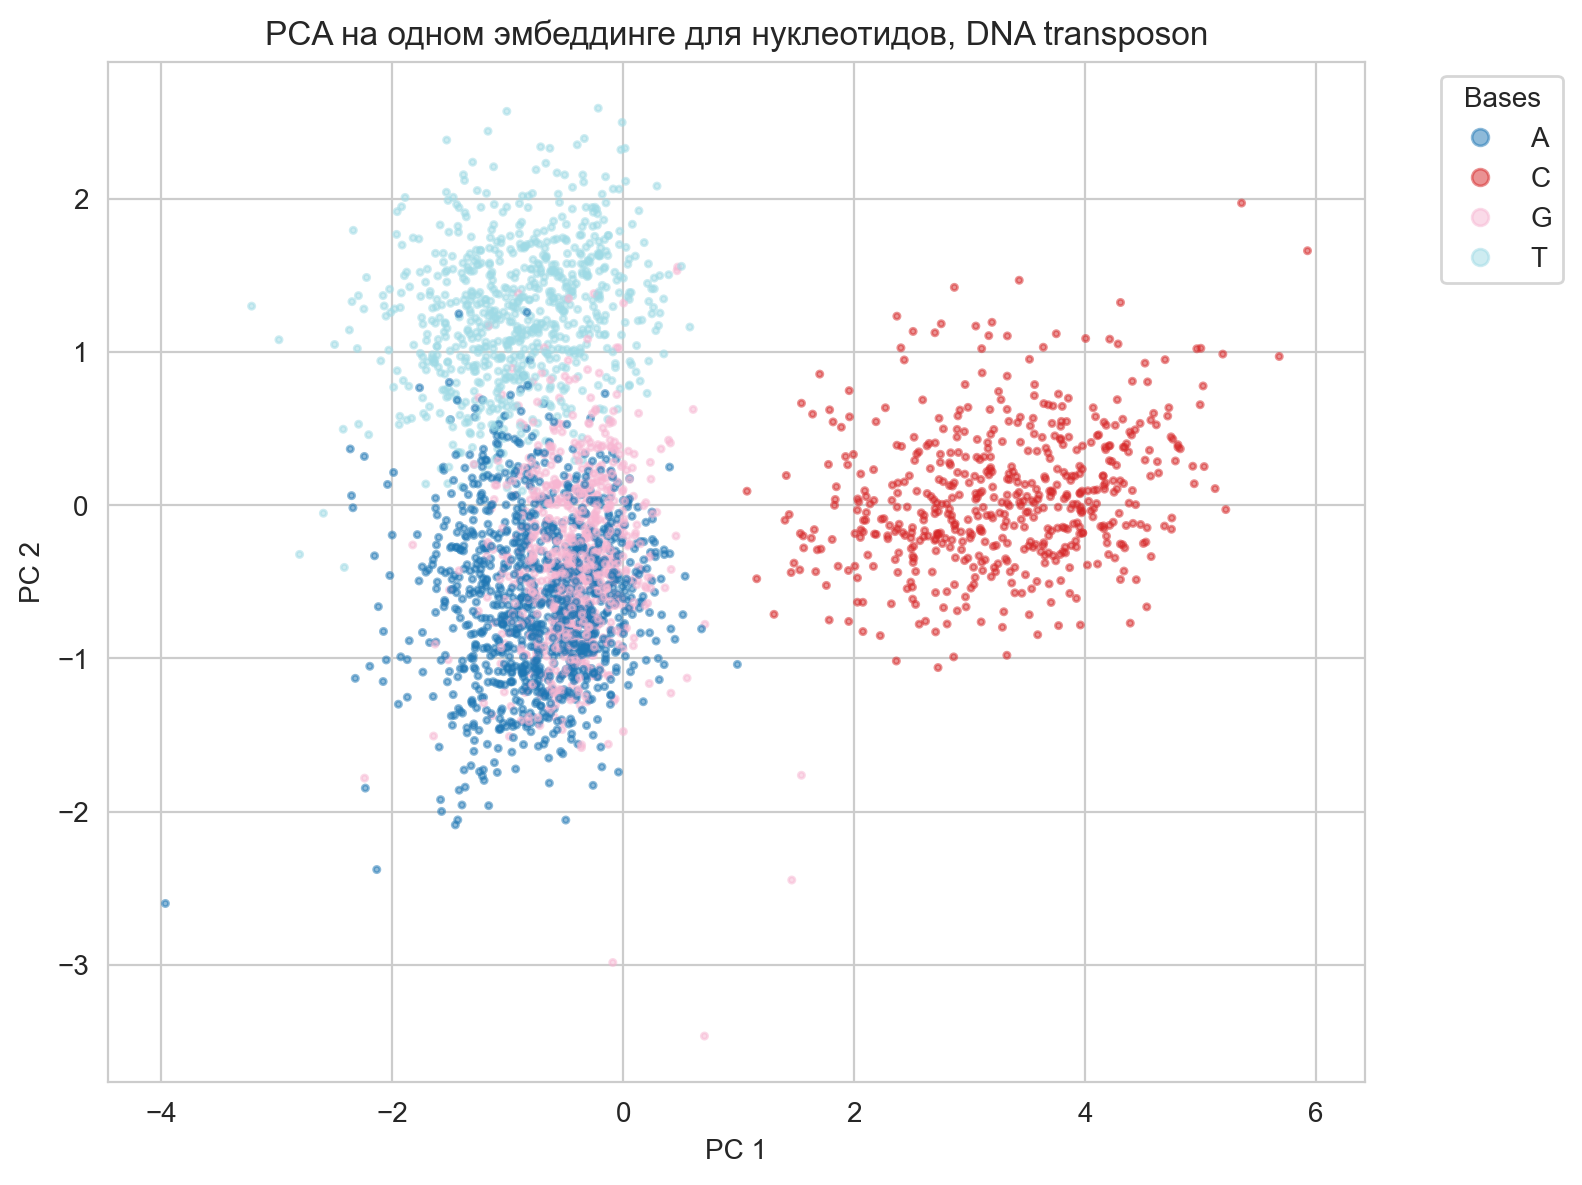

L1-9_LCh_L1_Latimeria_chalumnae


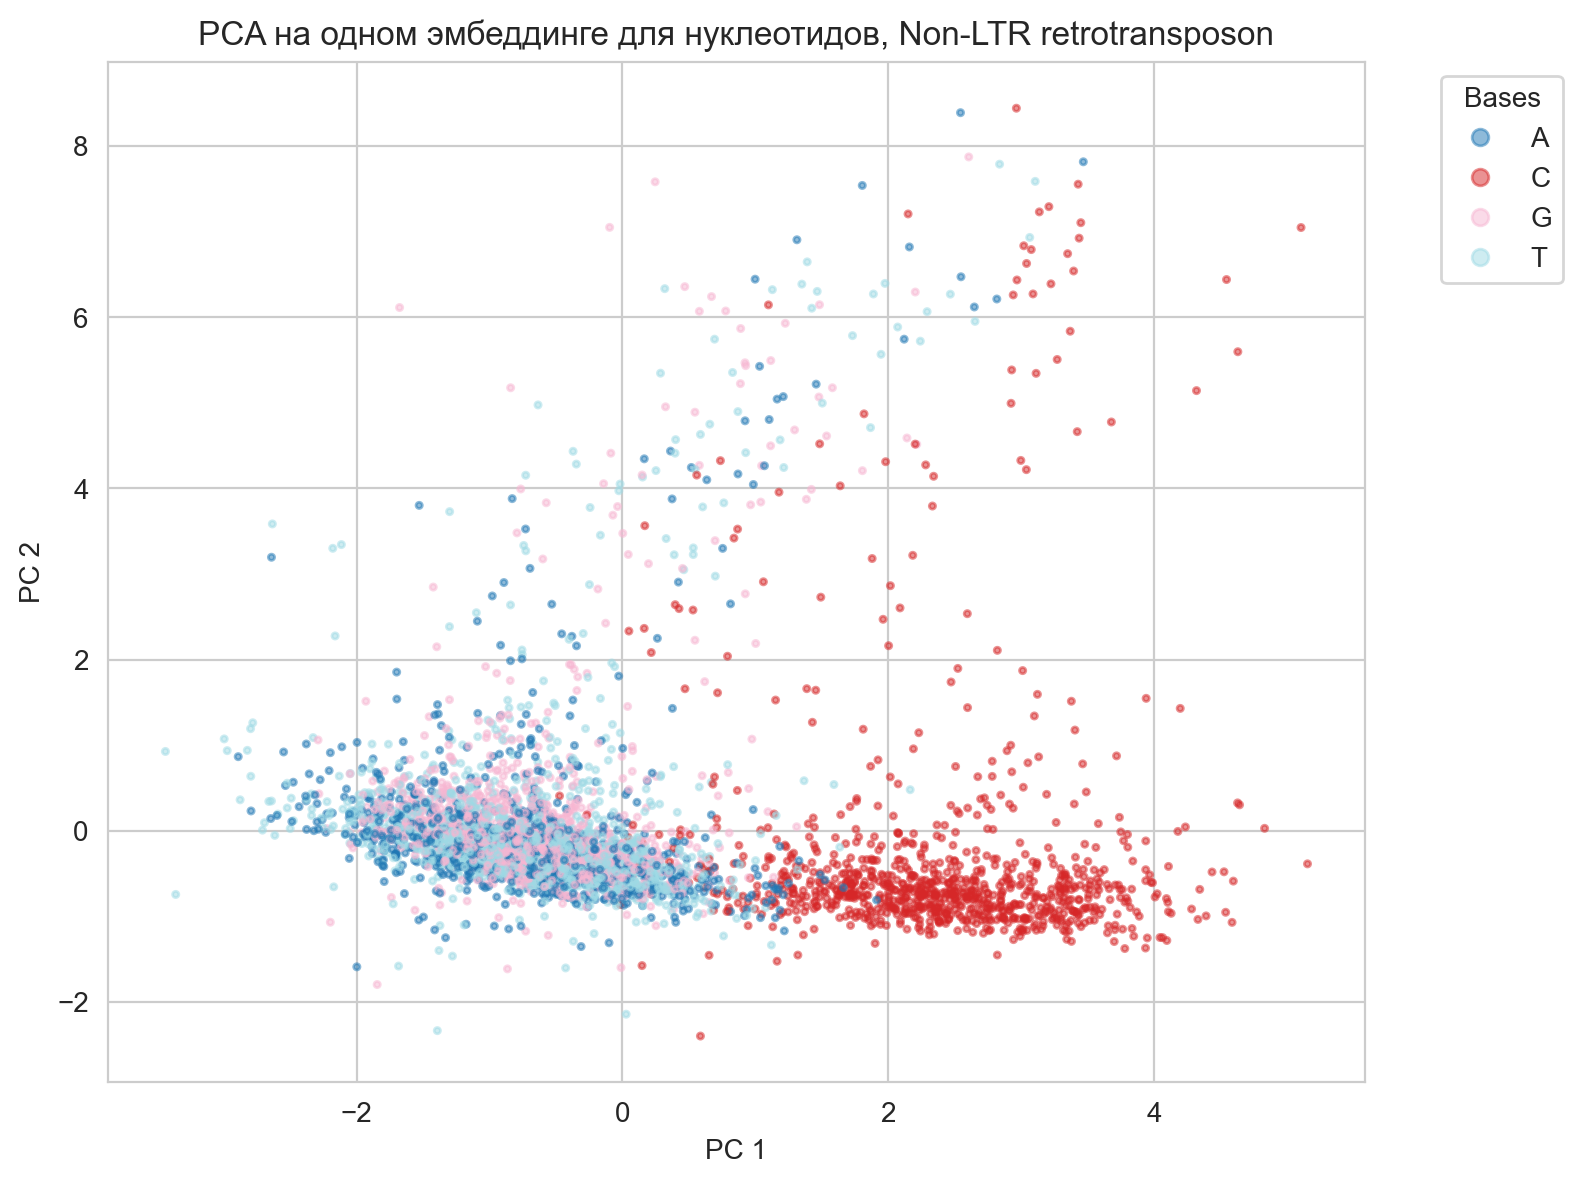

In [16]:
for i in range(len(names)):
    output = outputs[i][0][1:-1]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(output)

    sequence_list = list(sequences[i])

    valid_bases = {"A", "C", "G", "T"}
    mask = [base in valid_bases for base in sequence_list]

    X_pca = X_pca[mask]
    sequence_list = np.array(sequence_list)[mask]

    unique_labels = sorted(set(sequence_list))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_num[l] for l in sequence_list])

    print(names[i])
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=numeric_labels,
        cmap="tab20",
        s=5,
        alpha=0.5
    )
    handles, _ = scatter.legend_elements()
    plt.legend(handles, unique_labels, title="Bases", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"PCA на одном эмбеддинге для нуклеотидов, {types[i]}")
    plt.tight_layout()
    plt.show()

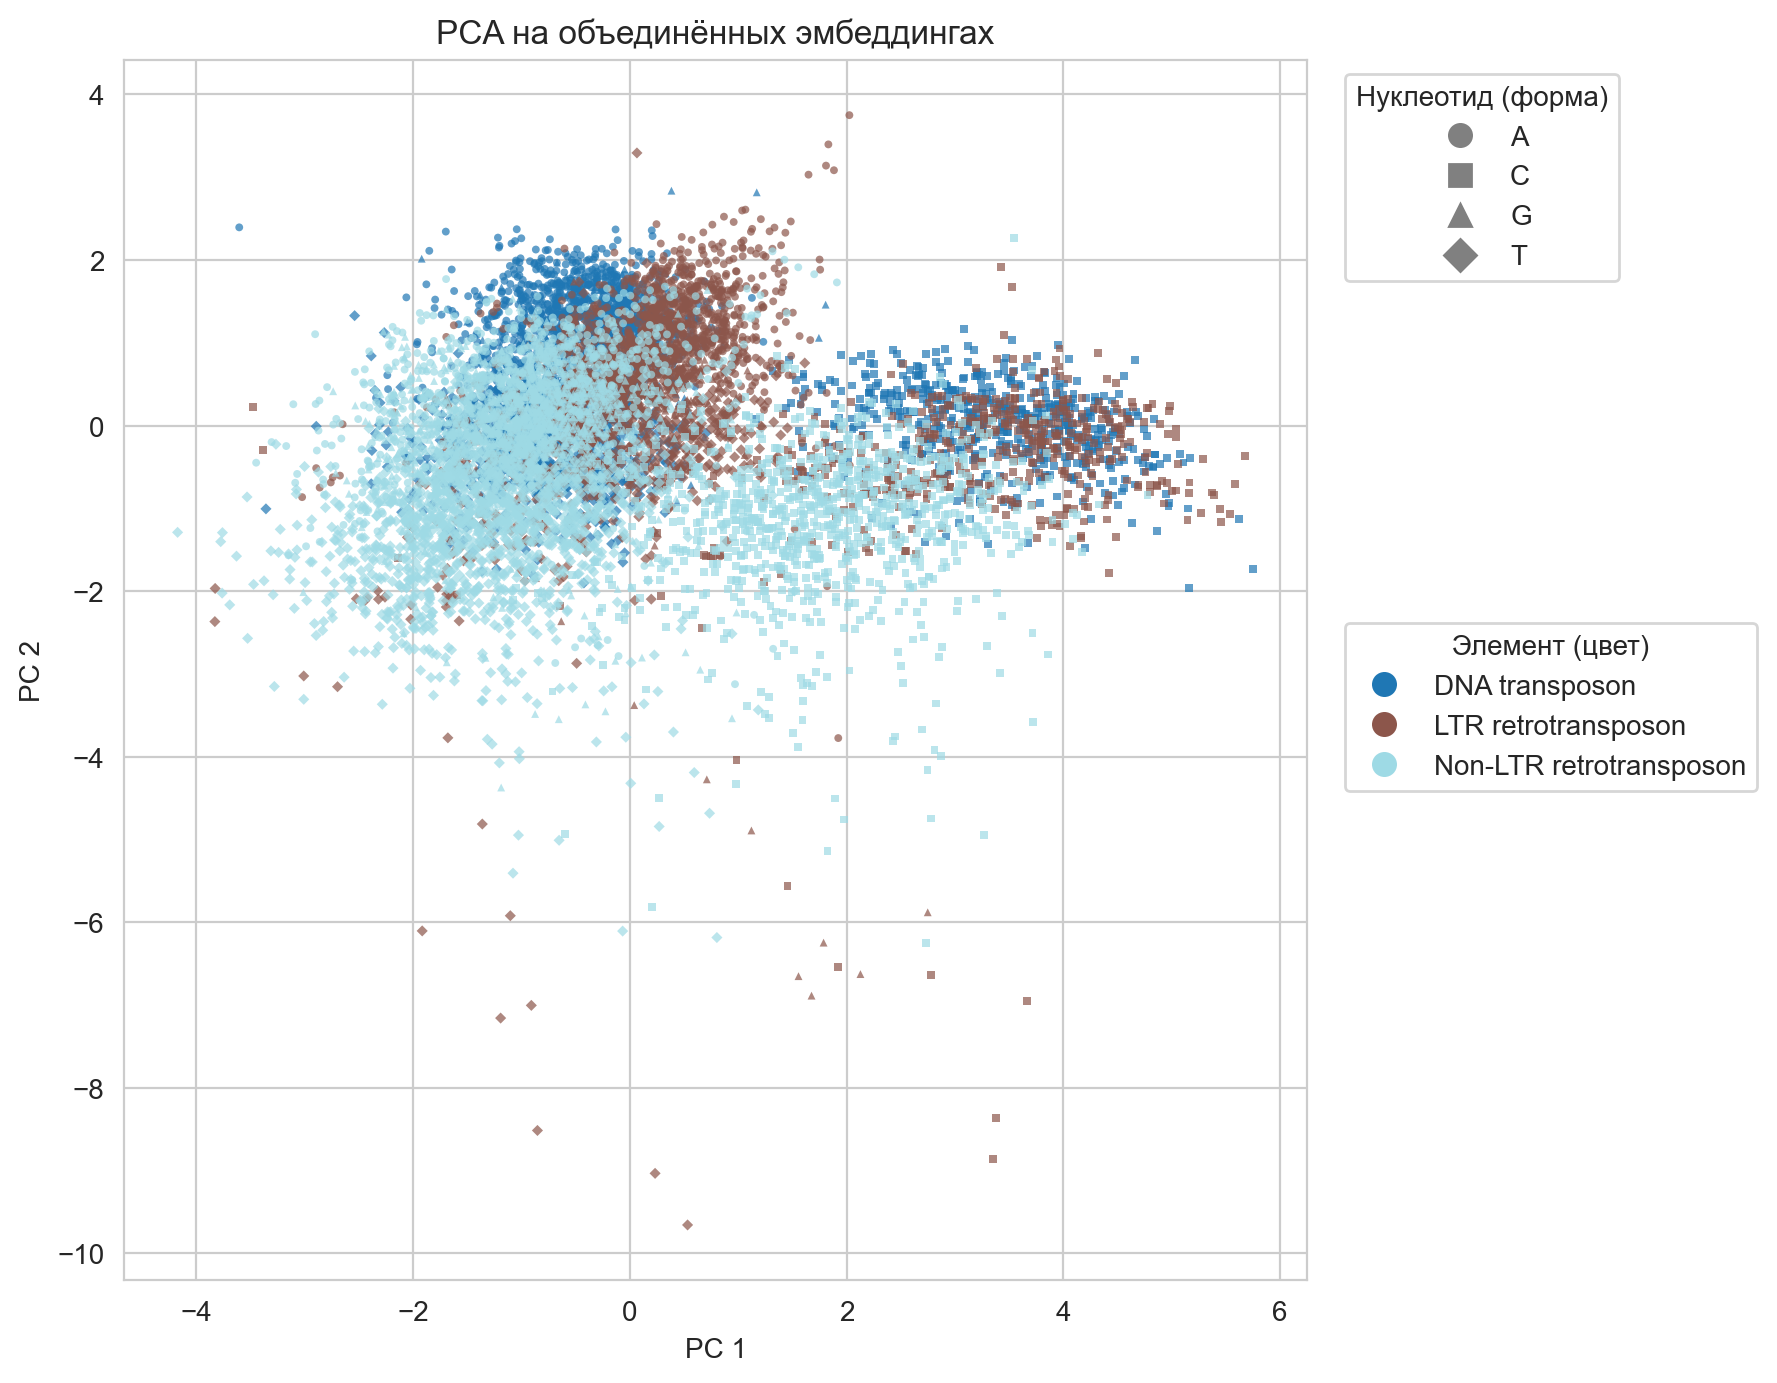

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

# ---- 1) собрать все данные в один общий массив ----
all_outputs = []
all_bases = []
all_elements = []  # будем брать из types[i] как "элемент"
valid_bases = {"A", "C", "G", "T"}

for i in range(len(names)):
    output = outputs[i][0][1:-1]           # (N_i, D)
    seq = list(sequences[i])               # длина N_i
    element_label = types[i]               # строка или метка для цвета

    # маска валидных нуклеотидов
    mask = [b in valid_bases for b in seq]
    output = output[mask]
    seq = np.array(seq)[mask]

    all_outputs.append(output)
    all_bases.append(seq)
    # для каждого нуклеотида в этом фрагменте записать элемент (одна и та же метка)
    all_elements.append(np.array([element_label] * len(seq)))

# склеиваем
X = np.vstack(all_outputs)              # (N_total, D)
bases = np.concatenate(all_bases)       # (N_total,)
elements = np.concatenate(all_elements) # (N_total,)

# ---- 2) общая PCA ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# ---- 3) стили: маркеры по нуклеотидам, цвета по элементам ----
base_to_marker = {"A": "o", "C": "s", "G": "^", "T": "D"}
unique_bases = ["A", "C", "G", "T"]

unique_elements = sorted(list(set(elements)))
# назначаем каждому элементу свой цвет из табличной палитры
# (если элементов > 20, можно взять plt.cm.get_cmap("tab20b") и т.д.)
cmap = plt.cm.get_cmap("tab20", len(unique_elements))
elem_to_color = {elem: cmap(j) for j, elem in enumerate(unique_elements)}

plt.figure(figsize=(9, 7))

# рисуем по сочетаниям (элемент -> база), чтобы цвет был по элементу, форма — по базе
for elem in unique_elements:
    for b in unique_bases:
        idx = np.where((elements == elem) & (bases == b))[0]
        if len(idx) == 0:
            continue
        plt.scatter(
            X_pca[idx, 0],
            X_pca[idx, 1],
            s=8,
            alpha=0.7,
            marker=base_to_marker[b],
            facecolor=elem_to_color[elem],
            edgecolor="none",
            linewidths=0,
        )

# ---- 4) две легенды: по базам (формы) и по элементам (цвета) ----
# легенда по базам (формы)
base_handles = [
    Line2D([0], [0], marker=base_to_marker[b], linestyle="",
           markersize=8, markerfacecolor="gray", markeredgecolor="gray", label=b)
    for b in unique_bases
]

# легенда по элементам (цвета)
elem_handles = [
    Line2D([0], [0], marker="o", linestyle="", markersize=8,
           markerfacecolor=elem_to_color[e], markeredgecolor=elem_to_color[e], label=str(e))
    for e in unique_elements
]

legend1 = plt.legend(handles=base_handles, title="Нуклеотид (форма)",
                     loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.gca().add_artist(legend1)
plt.legend(handles=elem_handles, title="Элемент (цвет)",
           loc="upper left", bbox_to_anchor=(1.02, 0.55))

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA на объединённых эмбеддингах")
plt.tight_layout()
plt.show()

In [8]:
data1 = outputs[0][0][1:-1]
data2 = outputs[1][0][1:-1]

seq1 = list(sequences[0])
seq2 = list(sequences[1])

unique_labels1 = sorted(set(seq1))
unique_labels2 = sorted(set(seq2))
label_to_num1 = {label: i for i, label in enumerate(unique_labels1)}
label_to_num2 = {label: i for i, label in enumerate(unique_labels2)}
numeric_labels1 = np.array([label_to_num1[l] for l in seq1])
numeric_labels2 = np.array([label_to_num2[l] for l in seq2])

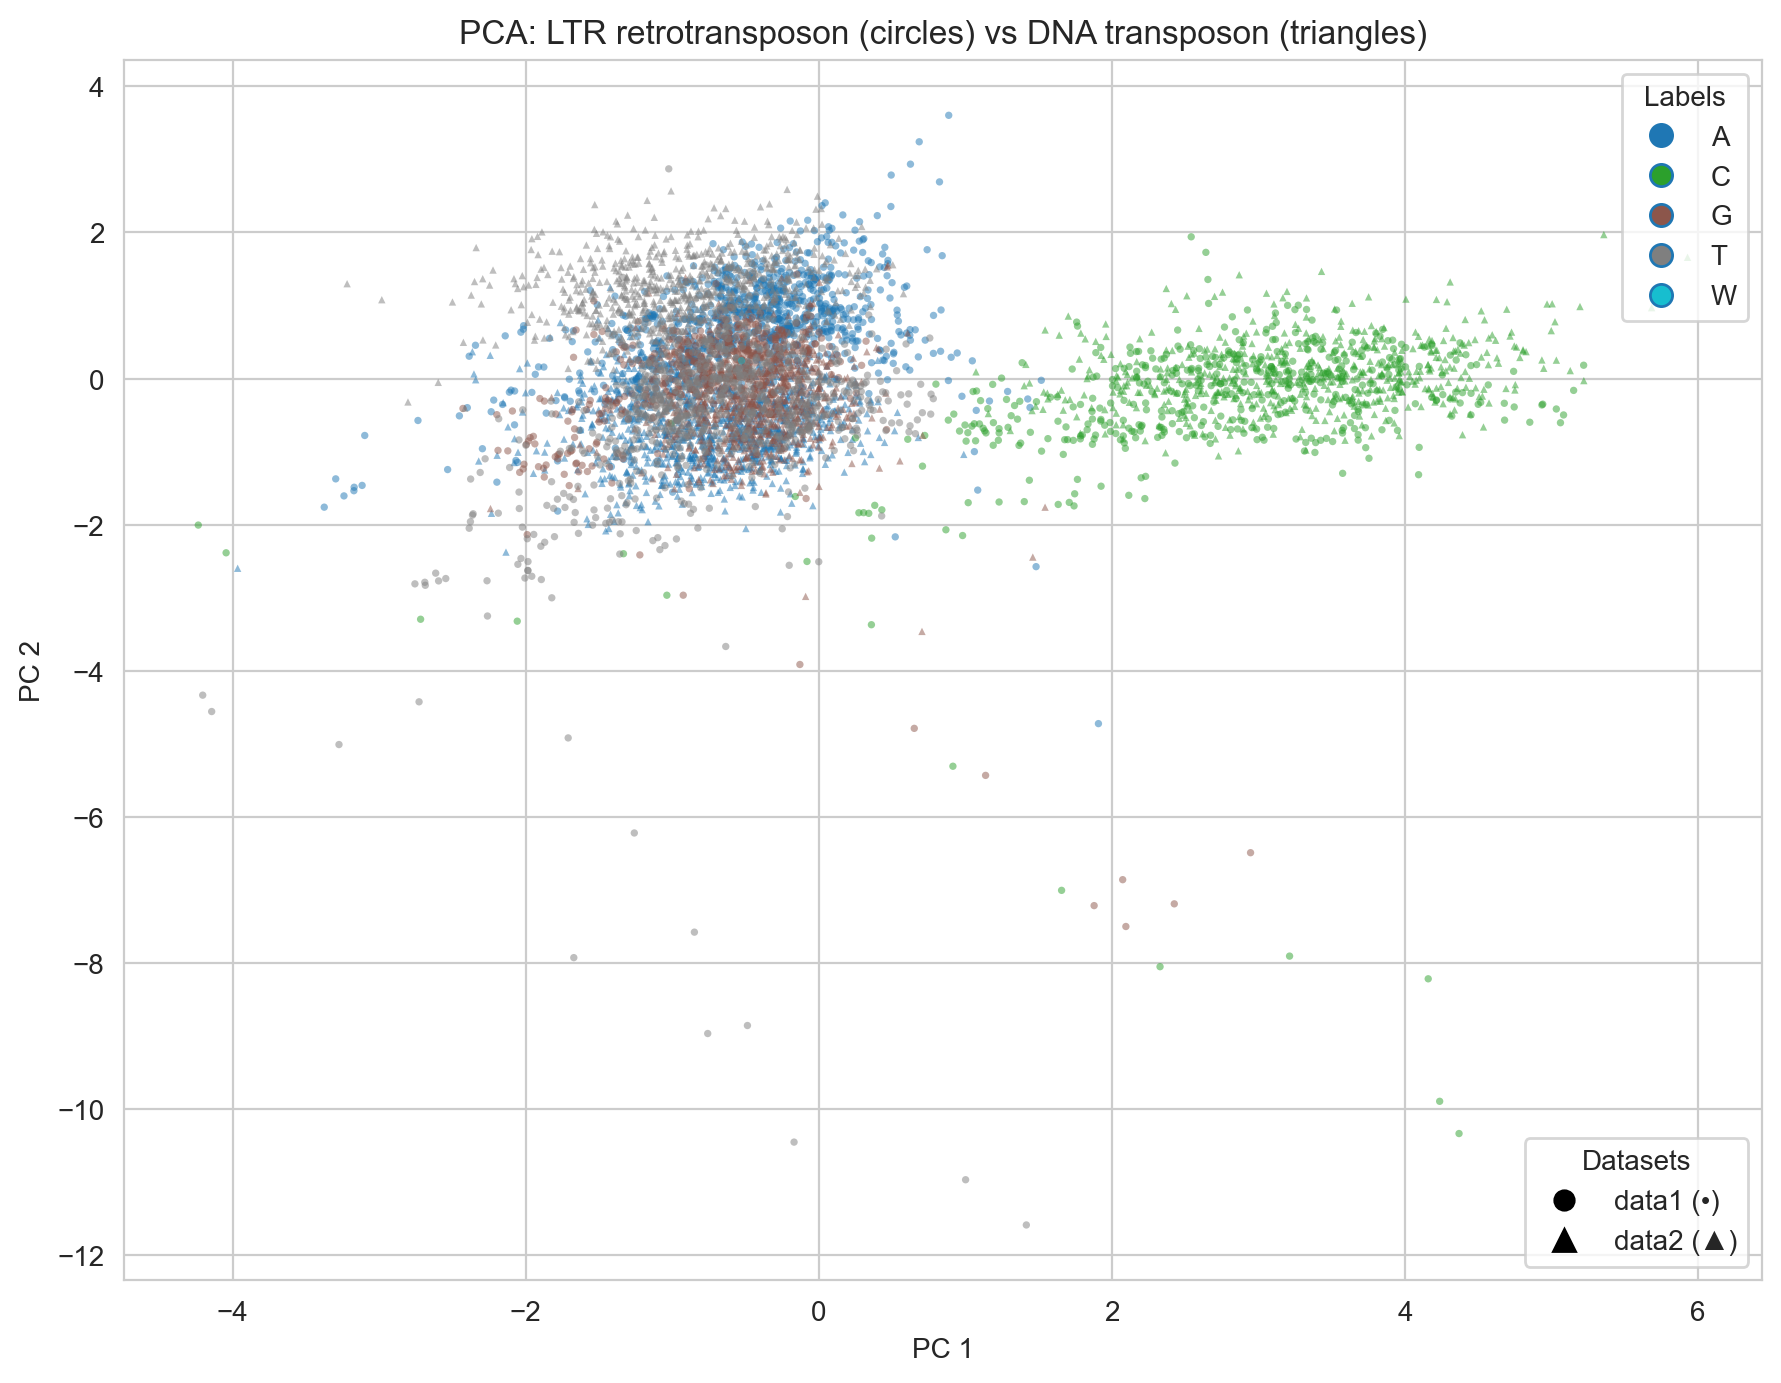

In [17]:
pca1 = PCA(n_components=2)
pca2 = PCA(n_components=2)
X_pca1 = pca1.fit_transform(data1)
X_pca2 = pca2.fit_transform(data2)

# Единый набор меток и единое сопоставление метка->цвет
all_labels = sorted(set(seq1) | set(seq2))
cmap = cm.get_cmap("tab10", len(all_labels))
label_to_color = {lab: cmap(i) for i, lab in enumerate(all_labels)}

# Удобные булевы маски по меткам
seq1_arr = np.array(seq1)
seq2_arr = np.array(seq2)

plt.figure(figsize=(9, 7))

for lab in all_labels:
    m1 = (seq1_arr == lab)
    m2 = (seq2_arr == lab)
    color = label_to_color[lab]

    # data1 — кружки
    if m1.any():
        plt.scatter(
            X_pca1[m1, 0], X_pca1[m1, 1],
            marker='o', s=7, alpha=0.5,
            edgecolors='none', facecolors=color
        )

    # data2 — треугольники
    if m2.any():
        plt.scatter(
            X_pca2[m2, 0], X_pca2[m2, 1],
            marker='^', s=7, alpha=0.5,
            edgecolors='none', facecolors=color
        )

label_handles = [Line2D([0], [0], marker='o', linestyle='',
                        markerfacecolor=label_to_color[lab], markersize=8, label=str(lab))
                 for lab in all_labels]

set_handles = [
    Line2D([0], [0], marker='o', linestyle='', color='k', markerfacecolor='k', markersize=7, label='data1 (•)'),
    Line2D([0], [0], marker='^', linestyle='', color='k', markerfacecolor='k', markersize=8, label='data2 (▲)'),
]

leg1 = plt.legend(handles=label_handles, title="Labels", loc="upper right", bbox_to_anchor=(1.0, 1.0))
plt.gca().add_artist(leg1)  # чтобы обе легенды одновременно отображались
plt.legend(handles=set_handles, title="Datasets", loc="lower right", bbox_to_anchor=(1.0, 0.0))

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"PCA: {types[0]} (circles) vs {types[1]} (triangles)")
plt.tight_layout()
plt.show()

In [10]:
types

['LTR retrotransposon', 'DNA transposon', 'Non-LTR retrotransposon']

In [11]:
all_labels = sorted(set(seq1) | set(seq2))

# фиксируем набор маркеров для классов (хватает на много классов)
marker_cycle = ['o','^','s','D']
if len(all_labels) > len(marker_cycle):
    raise ValueError(f"Нужно больше маркеров для {len(all_labels)} классов.")

label_to_marker = {lab: marker_cycle[i] for i, lab in enumerate(all_labels)}

# цвета по наборам данных (можешь поменять на любые)
color_data1 = '#1f77b4'  # синий
color_data2 = '#ff7f0e'  # оранжевый

seq1_arr = np.array(seq1)
seq2_arr = np.array(seq2)

plt.figure(figsize=(9, 7))

# Рисуем по классам: для каждого класса берем свой маркер,
# а цвет — в зависимости от набора (data1 или data2)
for lab in all_labels:
    m1 = (seq1_arr == lab)
    m2 = (seq2_arr == lab)
    marker = label_to_marker[lab]

    if m1.any():
        plt.scatter(
            X_pca1[m1, 0], X_pca1[m1, 1],
            marker=marker, s=8, alpha=0.5,
            facecolors=color_data1, edgecolors='none', label=None
        )
    if m2.any():
        plt.scatter(
            X_pca2[m2, 0], X_pca2[m2, 1],
            marker=marker, s=8, alpha=0.5,
            facecolors=color_data2, edgecolors='none', label=None
        )

# Легенда по классам (показываем разные маркеры, цвет нейтральный)
class_handles = [
    Line2D([0], [0], marker=label_to_marker[lab], linestyle='',
           markerfacecolor='none', markeredgecolor='black', markersize=8, label=str(lab))
    for lab in all_labels
]

# Легенда по наборам данных (одинаковые маркеры, разные цвета)
dataset_handles = [
    Line2D([0], [0], marker='o', linestyle='', color=color_data1, markerfacecolor=color_data1,
           markersize=8, label='data1'),
    Line2D([0], [0], marker='o', linestyle='', color=color_data2, markerfacecolor=color_data2,
           markersize=8, label='data2'),
]

leg1 = plt.legend(handles=class_handles, title="Классы (маркер)", loc="upper right")
plt.gca().add_artist(leg1)
plt.legend(handles=dataset_handles, title="Наборы (цвет)", loc="lower right")

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA: маркер = класс, цвет = набор данных")
plt.tight_layout()
plt.show()

ValueError: Нужно больше маркеров для 5 классов.